# Costa Rican Household Poverty Level Prediction

Costa Rican Household Poverty Level Prediction 대회의 목적은 개인과 가구 특성을 모두 사용하여 가구의 빈곤 수준을 예측할 수 있는 기계 학습 모델을 개발하는 것입니다.

이 노트북에서 우리는 완전한 기계 학습 솔루션을 살펴볼 것입니다. 먼저 문제를 소개하고 나서 데이터 세트에 대한 탐색적 데이터 분석을 수행하고, 피처 엔지니어링을 수행하고, 여러 기계 학습 모델을 시험해 보고, 모델을 선택하고, 모델을 최적화하기 위한 작업을 한 다음, 마지막으로 모델의 출력을 검사합니다.

## Problem and Data Explanation
이 대회의 데이터는 train.csv와 test.csv의 두 파일로 제공됩니다.
교육 세트에는 9557개의 행과 143개의 열이 있고 테스트 세트에는 23856개의 행과 142개의 열이 있습니다. 각 행은 한 개인을 나타내며 각 열은 개별 또는 개별 가정에 고유한 피처입니다. 교육 세트에는 1-4 규모의 빈곤 수준을 나타내는 타겟이라는 한 개의 추가 열이 있으며, 1은 가장 극심한 빈곤입니다.

이는 지도 학습의 다중 클래스 분류 기계 학습 문제입니다.

- Supervised(지도): 교육 데이터 레이블과 함께 제공됩니다.
- Multi-class classification(다중 클래스 분류): 레이블은 4개의 클래스가 있는 이산형 값입니다.

### Objective
목표는 빈곤을 가정의 측면에서 예측하는 것입니다. 우리는 개개인이 고유한 특징을 가지고 있는 개인 수준의 데이터와 그들의 가정에 대한 정보를 제공받습니다. 작업을 위한 데이터 세트를 생성하려면 각 가정에 대한 개별 데이터의 일부 집계를 수행해야 합니다. 게다가, 우리는 테스트 세트의 모든 개인들을 위해 예측을 해야 하지만, "집의 가장들만이 채점에 이용된다"는 것은 우리가 가구 단위로 가난을 예측하기를 원한다는 것을 의미합니다.

참고: 교육 데이터에 있는 모든 구성원의 라벨이 동일해야 하지만, 한 가구원의 라벨이  서로 다른 오류가 있습니다. 이 경우 각 가정의 가장에 대해 라벨을 사용하라는 지시를 받았습니다. 각 라벨은 parentesco1 == 1.0인 행으로 식별할 수 있습니다. 이 문제를 해결하는 방법에 대해 노트북에서 다룹니다

타겟은 다음과 같이 빈곤 수준을 나타냅니다.
- 1 = extreme poverty 
- 2 = moderate poverty 
- 3 = vulnerable households 
- 4 = non vulnerable households

143개의 열 중 몇 가지 참고할 사항이 있습니다.

- ID: 각 개인에 대한 고유 식별자, 이것은 우리가 사용하는 기능이 아니어야 합니다!
- idhogar: 각 가정에 대한 고유한 식별자입니다. 이 변수는 특성은 아니지만, 한 가구의 모든 개인이 동일한 식별자를 가지므로 가구별로 개인을 그룹화하는 데 사용됩니다.
- parentsco1: 이 사람이 가장인지 여부를 나타냅니다.
- Target: 가정의 모든 구성원에 대해 라벨이 동일해야 합니다.

우리가 모델을 만들 때, 우리는 가정마다 가장의 빈곤 수준을 나타내는 라벨을 붙이고 가구 단위로 훈련을 할 것입니다.
원시 데이터는 가구 및 개별 특성이 모두 혼합되어 있으며 개별 데이터의 경우 각 가구별로 이를 집계할 수 있는 방법을 찾아야 합니다. 개인들 중 일부는 가장이 없는 가정에 속해 있습니다. 불행히도 우리는 이 자료를 훈련에 사용할 수 없습니다. 데이터와 관련된 이러한 문제는 실제 데이터의 완전한 전형적인 문제이므로 데이터 과학 작업에서 발생할 수 있는 데이터셋에 대한 대비가 매우 중요합니다!



### Metric
궁극적으로 우리는 가정의 빈곤 수준을 예측할 수 있는 기계 학습 모델을 만들고자 합니다. 우리의 예측은 Macro F1 점수로 평가될 것입니다.

$ F_1 = 2 / (1/recall + 1/precision) = 2 \bullet precision \bullet recall/( precision + recall)$

다중 클래스 문제의 경우, 우리는 각 클래스의 F1 점수를 평균해야 합니다. Macro F1 점수는 레이블 불균형을 고려하지 않고 각 클래스의 F1 점수를 평균합니다.

$ Macro F_1 = 1/4 * (F_1Class1 + F_1Class2 + F_1Class3 + F_1Class4)$

즉, macro를 사용할 때(가중치 점수를 사용할 때) 각 라벨의 발생 횟수는 계산에 포함되지 않습니다. 성능을 평가하려면 다음 코드를 사용할 수 있습니다.

`from sklearn.metrics import f1_score
f1_score(y_true, y_predicted, average = 'macro')`

## Roadmap
최종 목표는 가정의 빈곤 수준을 예측할 수 있는 기계 학습 모델입니다. 하지만 모델링에 열중하기 전에 문제와 데이터를 이해하는 것이 중요합니다. 또한 여러 모형을 "최고"로 선택하기 전에 평가하고 모형을 만든 후 예측을 조사하려고 합니다. 따라서 우리의 로드맵은 다음과 같습니다.

1. 문제를 이해합니다.
2. 탐색적 데이터 분석을 진행합니다.
3. 피처 엔지니어링을 통해 머신 러닝을 위한 데이터 세트를 생성합니다.
4. 몇 가지 기본 기계 학습 모델을 비교합니다.
5. 좀 더 복잡한 기계 학습 모델을 시도해 봅니다.
6. 선택한 모델을 최적화합니다.
7. 문제의 맥락에서 모형 예측을 조사합니다.
8. 결론을 도출하고 다음 단계를 제시합니다.

위에 제시된 단계는 반복적 의미이지만, 한 번에 하나씩 검토하는 동안 이전 단계로 돌아가서 몇 가지 결정을 다시 검토할 수 있습니다. 일반적으로 데이터 과학은 과거의 결정을 지속적으로 평가하고 개선해야 하는 비선형적 관행입니다. 특히, 기능 엔지니어링, 모델링 및 최적화는 우리가 한 번에 제대로 이해했는지 알 수 없기 때문에 자주 반복하는 단계입니다!

## Getting Started
우리는 이 문제에 대해 상당히 잘 알고 있으므로 탐색적 데이터 분석(EDA)과 피처 엔지니어링으로 이동하겠습니다. EDA의 경우 피처 엔지니어링 및 모델링에 사용할 수 있는 흥미로운 이상 징후, 추세, 상관 관계 또는 패턴을 조사합니다. 우리는 반드시 데이터를 정량적으로(통계로) 그리고 시각적으로(숫자로) 조사해야 합니다.

일단 데이터와 잠재적으로 유용한 관계를 잘 파악하면, 우리는 피처 엔지니어링(기계 학습 파이프라인의 가장 중요한 부분)을 수행하고 기준 모델을 설정할 수 있습니다. 이것이 우리를 리더보드의 꼭대기에 오르게 하지는 않을 것이지만, 그것은 기초 위에 세울 강력한 기반을 제공할 것입니다.


### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information

In [2]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개의 정수형 열, 8개의 실수 열, 5개의 오브젝트 열이 있습니다. 정수 열은 대부분 불린 변수거나 순서형 변수로 보입니다. 오브젝트 열은 결측치가 포함된 열로 추측됩니다.

test 데이터에는 타겟 열이 없습니다. 살펴보겠습니다.

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer Columns
정수형 열의 값 분포를 살펴보겠습니다. 각 열에 대해 빈도를 세고 그림으로 그리겠습니다.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

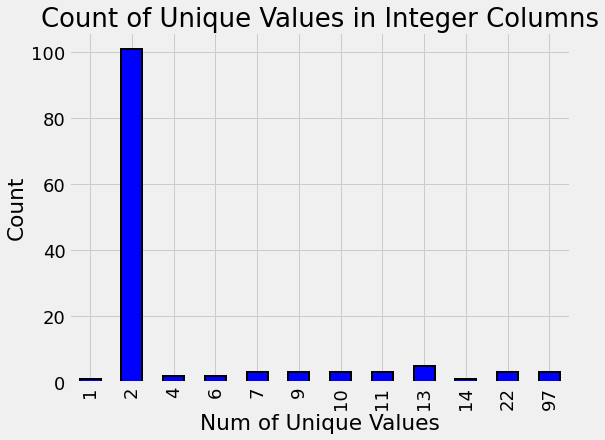

In [5]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8, 6), edgecolor = 'k', linewidth=2)

plt.xlabel('Num of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

2개의 고유값이 있는 열은 불린을 나타냅니다. 대부분의 경우 이 불린 정보는 가구 수준에 있습니다. 예를 들어, refrig 열에는 가정에 냉장고가 있는지 없는지 적혀 있습니다. 개별 수준에 있는 불린 열을 집계해야 합니다.

#### float columns
또 다른 열 유형은 연속형 변수를 나타내는 실수형입니다. 모든 실수 열의 분포를 표시하기 위해 빠른 분포도를 만들 수 있습니다. 일반 Python 사전과 달리 키 및 값이 지정된 순서대로 유지되므로 OrderdDict를 사용하여 빈곤 수준을 색상으로 매핑합니다.

다음 그래프는 타겟값으로 색칠된 실수 열의 분포를 보여 줍니다. 이러한 그림을 통해 가계 빈곤 수준에 따라 변동 분포에 큰 차이가 있는지 확인할 수 있습니다.

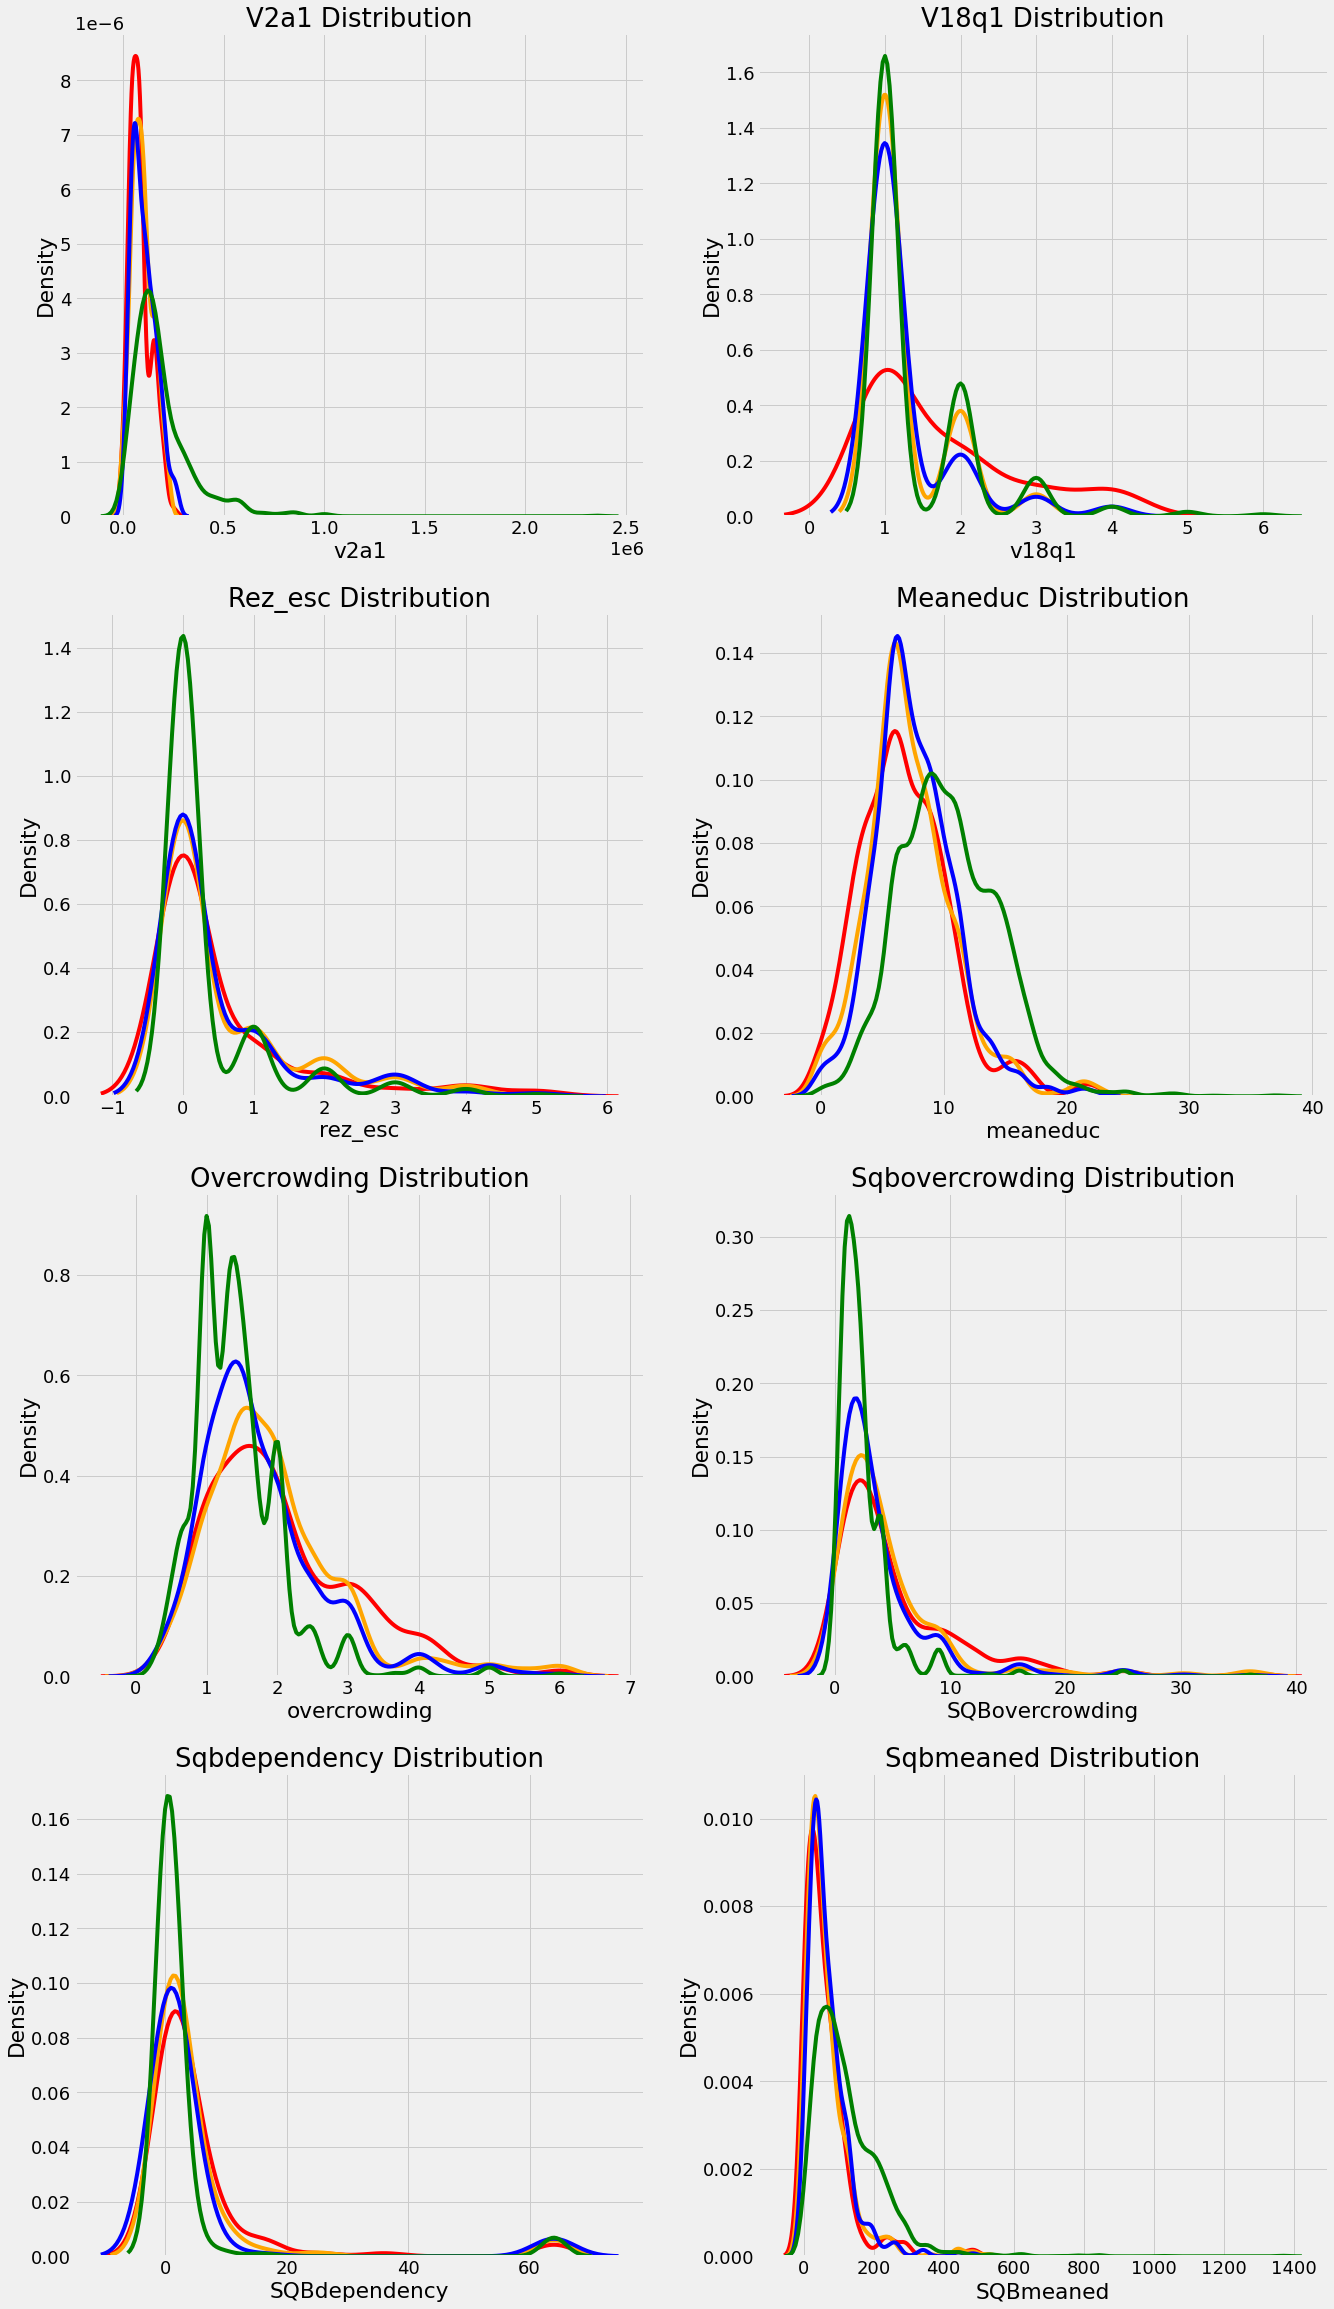

In [6]:
from collections import OrderedDict

plt.figure(figsize=(20, 16))

# Color mapping
colors = OrderedDict({1:'red', 2:'orange', 3:'blue', 4:'green'})
poverty_mapping = OrderedDict({1:'extreme', 2:'moderate', 3:'vulnerable', 4:'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i+1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as as seperate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                   ax = ax, color=color, label=poverty_mapping[poverty_level])
        plt.title(f'{col.capitalize()} Distribution')
        plt.xlabel(f'{col}')
        plt.ylabel('Density')
        
plt.subplots_adjust(top=2)

나중에 변수와 타겟값 사이의 상관 관계를 계산하여 형상 간의 관계를 측정하지만 이러한 그림은 이미 어느 변수가 모형에 가장 "관련성이 있는" 변수인지 파악할 수 있습니다. 예를 들어, 가정 내 성인들의 평균 교육을 나타내는 meaneduc은 빈곤 수준과 관련이 있는 것으로 보입니다: 더 높은 평균 성인 교육은 보다 덜 심각한 빈곤 수준인 목표의 더 높은 가치로 이어집니다. 

#### Object Columns
Id 및 idhoger은 식별 변수이기 때문에 의미가 있습니다. 그러나 다른 열들은 기계 학습을 하기 전에 우리가 해결해야 할 문자열과 숫자의 혼합인 것 같습니다. 다음 열에 대한 설명서에 따릅니다.

- dependecy: 의존율은 (19세 이하 또는 64세 이상 가구원 수)/(19세 이상 가구원 수)로 계산됩니다.
- edjefe: 남성 가장의 교육 연수로, escolari(교육 연수)와 상호작용하며, 가장과 성별여부에도 연관있습니다.
- edjefa: 여성 가장의 교육 연수로, escolari(교육 연수)와 상호작용하며, 가장과 성별여부에도 연관있습니다.

이 세 변수에 대해 yes=1, no=0으로 바꾸겠습니다.

In [7]:
mapping = {'yes':1, 'no':0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


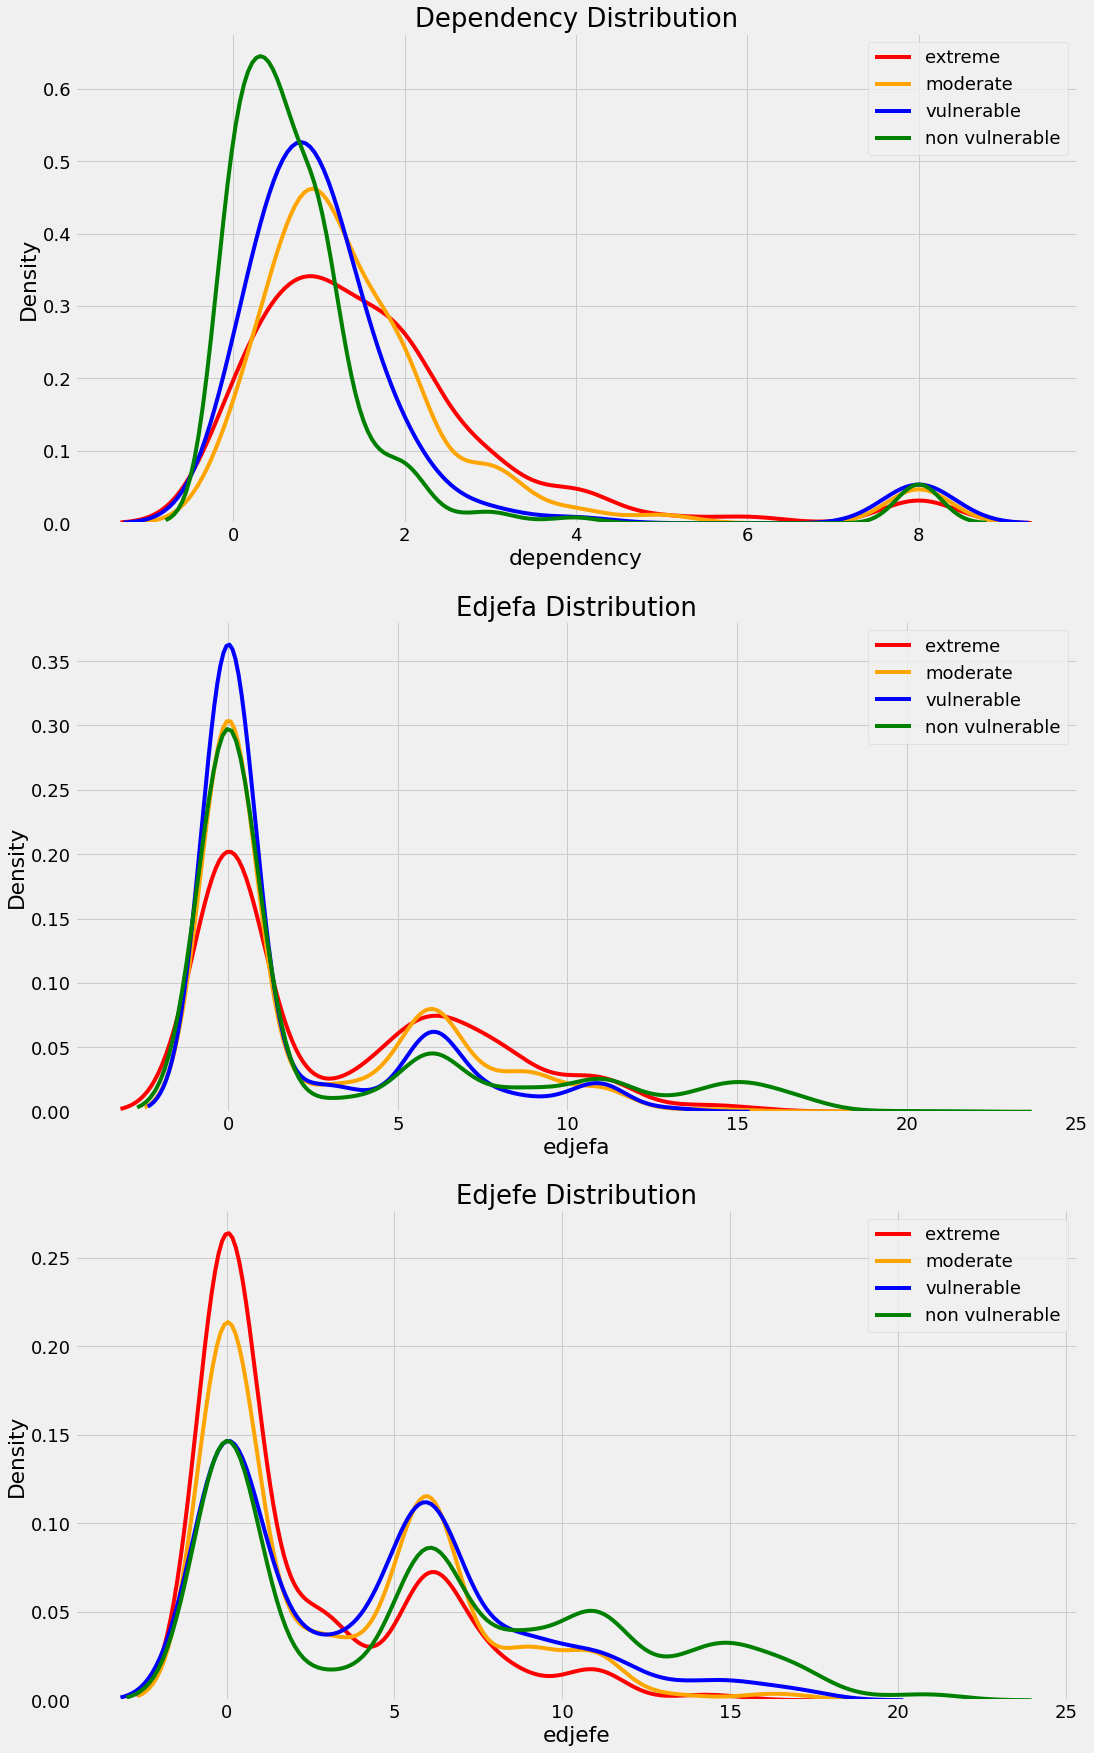

In [8]:
plt.figure(figsize=(16,12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i+1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as seperate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
        plt.title(f'{col.capitalize()} Distribution')
        plt.xlabel(f'{col}')
        plt.ylabel('Density')
        plt.legend()
        
plt.subplots_adjust(top=2)

이러한 변수는 이제 숫자로 올바르게 표현되고 기계 학습 모델에 입력될 수 있습니다.

위와 같은 작업을 좀 더 쉽게 수행하기 위해 교육 및 테스트 데이터 프레임을 조인할 것입니다. 피처 엔지니어링을 시작한 후에는 두 데이터 프레임에 동일한 작업을 적용하여 동일한 기능을 제공하고자 하기 때문에 이러한 기능이 중요합니다. 나중에 타겟에 따라 세트를 분리할 수 있습니다.

In [9]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

## Exploring Label Distribution
다음으로, 우리는 레이블의 분포를 보면 문제가 얼마나 불균형한지 알 수 있습니다. 네 가지 다른 수준의 빈곤을 나타내는 네 가지 정수가 있습니다. 올바른 레이블을 보려면 parentesco1 == 1 (가장이 있는 경우)에 해당하는 열에대해 부분 집합을 취합니다.

아래 막대 그림은 (테스트 레이블이 없기 때문에) 교육용 레이블의 분포를 보여줍니다.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

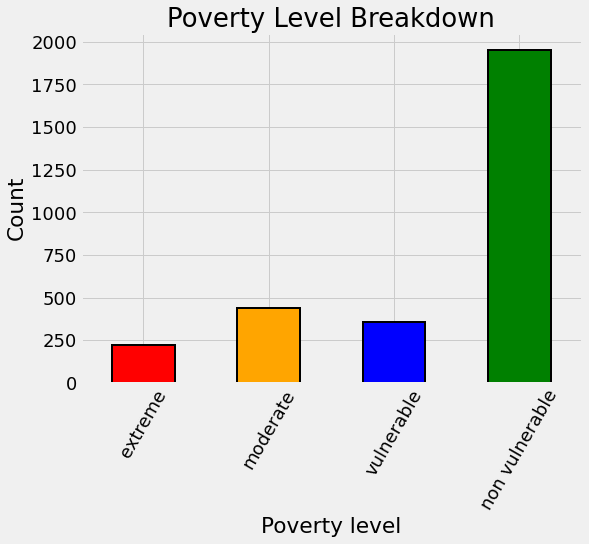

In [10]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize=(8,6),
                     color=colors.values(),
                     edgecolor='k', linewidth=2)

# Formatting
plt.xlabel('Poverty level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()],
          list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')

label_counts

불균형 클래스 문제를 다루고 있습니다(이것은 대회 주최자가 가중 F1 대신 macro F1 점수를 메트릭으로 선택하는 이유를 흥미롭게 만듭니다!). 비취약계층으로 분류되는 가구가 다른 카테고리보다 훨씬 많습니다. 극빈층은 가장 작습니다.

불균형 분류 문제의 한 가지 문제는 기계 학습 모델이 훨씬 적은 예를 보기 때문에 소수 계층을 예측하는 데 어려움을 겪을 수 있다는 것입니다. 만약 우리가 빈곤을 분류하고 있고, 극심한 빈곤보다 빈곤이 없는 경우를 훨씬 더 많이 본다면, 노출이 적기 때문에 우리가 빈곤층 가정을 확인하기가 더 어려워질 것입니다. 

## Addressing Wrong Labels
현실적인 데이터 세트와 마찬가지로 코스타리카 빈곤 데이터에도 몇 가지 문제가 있습니다. 일반적으로 데이터 과학 프로젝트의 80%는 데이터를 정리하고 이상 징후/오류를 수정하는 데 사용됩니다. 이는 인간 입력 오류, 측정 오류 또는 때로는 정확하지만 눈에 띄는 극단값일 수 있습니다. 이 문제의 경우, 같은 가구의 개인의 빈곤 수준이 다른 현상이 있습니다. 왜 그런지는 모르지만, 우리는 가장을 진짜 라벨로 사용하라고 합니다.

그 정보는 우리의 일을 훨씬 더 쉽게 만들어주지만, 현실의 문제에서는, 우리는 왜 라벨이 잘못되었는지와 어떻게 우리 스스로 그 문제를 해결해야 하는지 그 이유를 알아내야 할 것입니다. 이 섹션에서는 라벨에 문제가 있는 경우 반드시 해결해야 하는 것은 아니지만, 이 문제를 어떻게 처리할 수 있는지 보여 주기 위해 노트에 보관했습니다.

### Identify Errors
먼저 오류를 수정하기 전에 오류를 찾아야 합니다. 가족 구성원에 대해 서로 다른 레이블을 가진 가구를 찾기 위해 가구별로 데이터를 그룹화한 다음 타겟값이 하나만 있는지 확인할 수 있습니다.

In [11]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [12]:
# One Example
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최 측은 올바른 라벨은 가장(parentesco1 == 1인 경우)에 대한 라벨이라고 말합니다. 이 가정의 경우, 모든 구성원에 대해 올바른 라벨은 3입니다. 우리는 이 가정의 모든 개인에게 올바른 빈곤 수준을 재지정함으로써 이것을 고칠 수 있습니다.

### Families without Heads of Household
만약 가장이 없는 가정이 있고, 그 가족 구성원들이 다른 라벨을 가지고 있다면 어떡할까요? 한번 조사해보겠습니다.

In [13]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [14]:
# Find households without a head where lables are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal==False)))

0 Households with no head have different labels.


다행히 가장이 없고 라벨이 다른 경우는 없습니다. 이 문제에 대해 주최 측에 따르면, 가장이 없다면, 참된 라벨이 없다고 합니다. 따라서, 우리는 사실 교육용 데이터에서 가장이 없는 가정은 사용하지 않을 것입니다. 그럼에도 불구하고, 데이터를 조사하는 이러한 과정을 거치는 것은 여전히 좋은 연습입니다!

### Correct Errors
이제 우리는 가장을 가진 가구와 다른 빈곤 수준을 가진 가구들에 대한 라벨을 수정할 수 있습니다.

In [15]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

# Households where target are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


라벨에는 가장만 사용할 예정이기 때문에 이 단계가 완전히 필요한 것은 아니지만 실제 발생할 수 있는 데이터 오류를 수정하는 작업흐름을 보여줍니다.

## Missing Variables
EDA의 가장 중요한 단계 중 하나는 데이터에서 결측값을 찾아 처리하는 방법을 결정하는 것입니다. 결측값은 기계 학습 모델을 사용하기 전에 입력해야 합니다. 이 기능을 기반으로 입력하기 위한 최상의 전략을 생각해야 합니다. 여기서부터 데이터 정의를 조사해야 합니다.

먼저 각 열에 있는 결측값의 백분율을 확인할 수 있습니다.

In [16]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


테스트 데이터를 위해 NaN을 만들었으므로 타겟에 대해 걱정할 필요가 없습니다. 그러나 결측값의 비율이 높은 나머지 세 열은 반드시 해결해야 합니다.

가족 소유의 태블릿 수를 나타내는 v18q1부터 살펴보겠습니다. 이게 가구 변수이기 때문에 가계 차원에서만 보는 게 타당하기 때문에 가장을 위한 행만 선택하도록 하겠습니다.

### Function to Plot Value Counts
서로 다른 열에 대한 값 개수를 표시할 수 있으므로, 이를 위해 사용할 간단한 함수를 작성할 수 있습니다!

In [17]:
def plot_values_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize=(8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                edgecolor = 'k',
                                                linewidth = 2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} Value Counts')
    plt.ylabel('Count')
    plt.show()

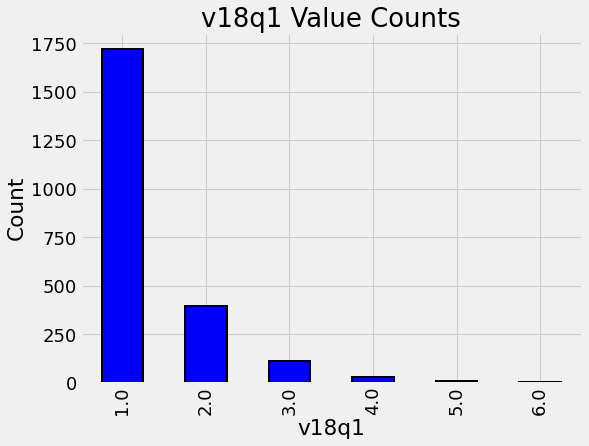

In [18]:
plot_values_counts(heads, 'v18q1')

현재 존재하는 데이터만 사용한다면 가장 많이 소유하는 태블릿 수는 1개인 것 같습니다. 하지만 누락된 데이터도 생각해야 합니다. 이 경우, 이 범주의 결측치가 있는 가정은 태블릿을 소유하지 않는 것일 수 있습니다. 데이터 정의를 살펴보면 v18q는 가족이 태블릿을 소유하는지 여부를 나타냅니다. 우리는 이 열을 태블릿 수와 결합하여 가설이 유지되는지 확인해야 합니다.

v18q 값(테이블을 소유하는 경우 1이고 소유하지 않는 경우 0)을 기준으로 그룹화한 다음 v18q1에 대한 null 값의 수를 계산할 수 있습니다. Null 값이 패밀리가 태블릿을 소유하지 않음을 나타내는지를 알려줍니다.

In [19]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

v18q1 의 결측치는 태블릿을 가지고 있지 않는 가정으로 판별됐습니다. 따라서 결측치를 0으로 채우겠습니다.

In [20]:
data['v18q1'] = data['v18q1'].fillna(0)

다음 누락된 열은 월세 납부를 나타내는 v2a1입니다.

월세 납부의 결측치를 살펴보는 것 외에도 주택의 소유/임대 현황을 보여주는 칼럼인 tipovivi_의 분포도 함께 살펴보는 것이 흥미로울 것입니다. 우리는 월세 지불에 대한 결측치와 함께 소유 현황을 살펴보겠습니다.

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

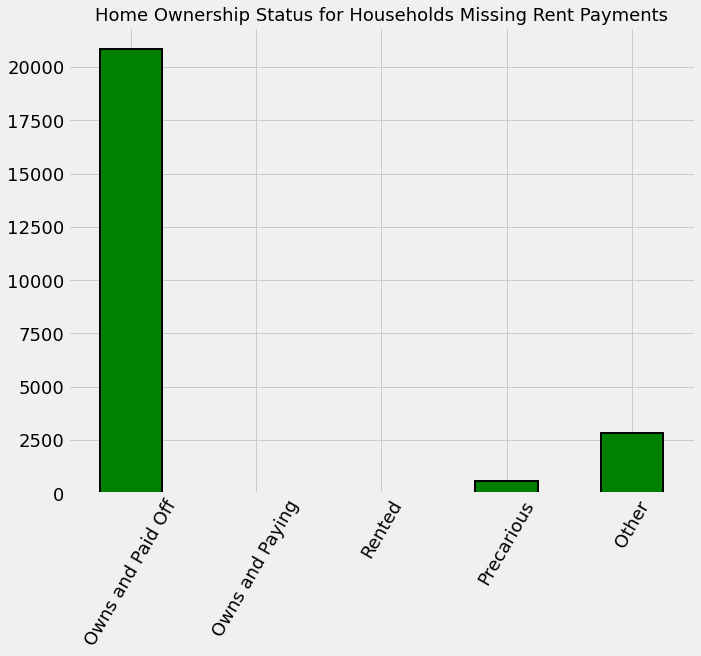

In [21]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

# Plot of the home ownership variables for home missing rent paymnets
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10,8), color='green', edgecolor='k', linewidth=2)
plt.xticks([0, 1, 2, 3, 4], ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'], rotation=60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size=18)

주택 소유 변수의 의미는 다음과 같습니다.

`
tipovi1 =1 완전 본인 소유 주택
tipovi2 =1 소유했지만, 할부로 결제
tipovi3 =1 임대
tipovi4 =1 불안정
tipovi5 =1 기타(차용 등)
`

대부분 월세를 내지 않는 가구들은 대개 자신의 집을 소유합니다. 다른 몇 가지 상황에서는 정보가 누락된 이유를 알 수 없습니다.

보유 주택에 월세 미납 주택에 대해서는 월세 지급액을 0으로 설정할 수 있습니다. 다른 가정에서는 결측값을 귀속시킬 수 있지만 이러한 가정이 결측값을 가지고 있음을 나타내는 플래그(불린) 열을 추가합니다.

In [22]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

__rez_esc__: 결측값의 비율이 높은 마지막 열은 학창시절보다 몇 년 늦었다는 것을 나타냅니다. 결측값을 가진 가정의 경우, 현재 학교에 자녀가 없을 수 있습니다. 이 열에 결측값이 있는 사람의 나이와 결측값이 없는 사람의 나이를 알아봄으로써 이것을 시험해 보겠습니다.

In [23]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

이것이 우리에게 말해주는 것은 가장 오래된 나이는 17세라는 것입니다. 이것보다 나이가 많은 사람들에게, 우리는 그들이 단순히 현재 학교에 있지 않다고 가정할 수 있을지도 모릅니다. 결측된 사람들의 나이를 살펴보겠습니다.

In [24]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

이 대회에 대한 토론의 일부를 읽어보면, 이 변수는 7세에서 19세 사이의 개인에게만 정의된다는 것을 알게 됩니다. 이 범위보다 어리거나 나이가 많은 사람은 아마도 나이보다 뒤쳐지지 않으므로 값을 0으로 설정해야 합니다. 이 변수의 경우 7보다 어리거나 19살을 넘고, 결측값이 있는 경우 0으로 설정할 수 있습니다. 다른 사용자의 경우 값을 귀속시키고 불린 플래그를 추가합니다.

In [25]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc 열에도 하나의 이상치가 있습니다. 경쟁 토론에서 읽어보면, 우리는 이 변수의 최대값이 5라는 것을 알게 됩니다. 따라서 5 이상의 값은 5로 설정해야 합니다.

In [26]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

## Plot Two Categorical Variables
두 범주형 변수가 서로 어떻게 상호 작용하는지를 보여 주기 위해 산점도, 면봉 그림, 상자 그림 등의 여러 가지 표시 옵션이 있습니다. 저는 이러한 선택에 만족하지 못해서 아래에 함수를 작성했습니다. 기본적으로 점의 크기가 각 x값으로 표시되는 특정 y값의 백분율을 나타내는 두 개의 범주형 범주로 구성된 산점도입니다.

In [27]:
def plot_categoricals(x, y, data, annotate=True):
    # Raw counts
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x:'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: "normalized_count"}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize=(14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolors='k', color='lightgreen', s=100*np.sqrt(counts['raw_count']), marker='o', alpha=0.6, linewidths=1.5)
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy=(row[x]-(1/counts[x].nunique()),
                             row[y]-(0.15/counts[y].nunique())),
                         color='navy', s=f"{round(row['percent'],1)}%")
    
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max, int((sqr_max-sqr_min)/5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s=100*size,
                                  label=f'{int(round(np.square(size)/100) * 100)}',
                                  color = 'lightgreen',
                                  alpha = 0.6,
                                  edgecolors='k',
                                  linewidths=1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title='Counts',
              labelspacing=3, handletextpad=2,
              fontsize=16, loc=(1.10, 0.19))
    
    plt.annotate(f'*Size represents raw count while % is for a given y value.', 
                xy = (0, 1), xycoords = 'figure points', size=10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6/counts[x].nunique()),
             counts[x].max() + (6/counts[x].nunique())))
    plt.ylim((counts[y].min() - (4/counts[y].nunique()),
             counts[y].max() + (4/counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f'{y} vs {x}')

<ipython-input-27-2f73ba78de83>:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy=(row[x]-(1/counts[x].nunique()),


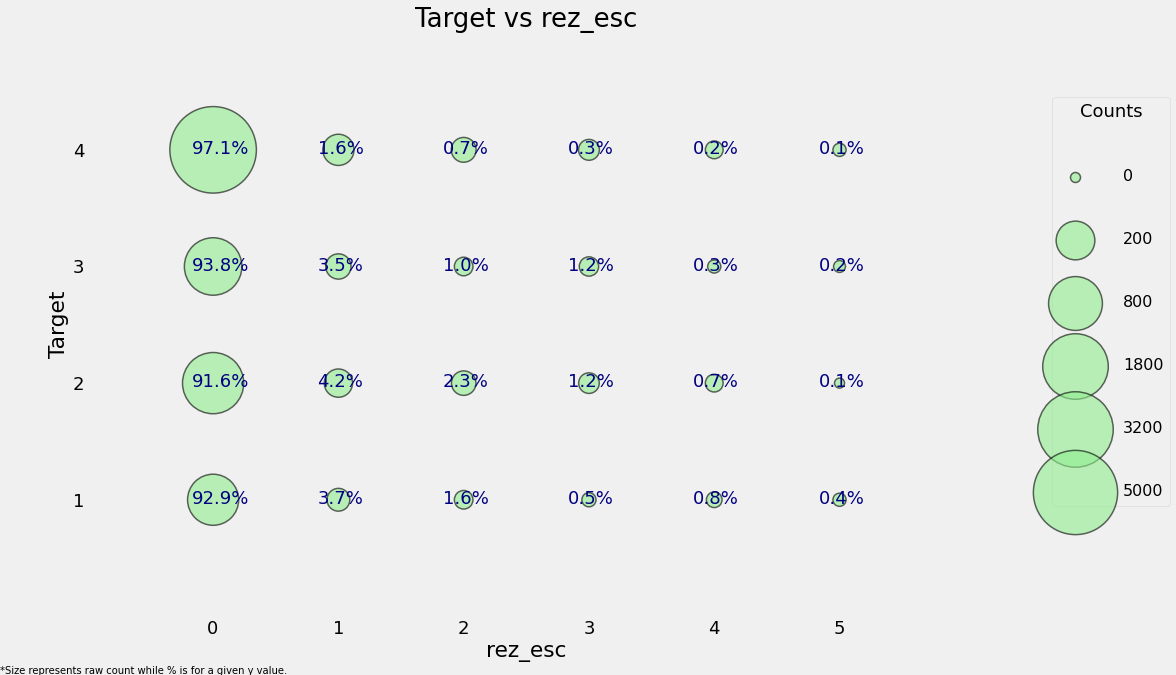

In [28]:
plot_categoricals('rez_esc', 'Target', data)

마커의 크기는 원시 카운트를 나타냅니다. 그래프를 읽으려면 지정된 y-값을 선택한 다음 행을 가로질러 읽으십시오. 예를 들어, 빈곤 수준이 1인 경우 93%의 개인은 800명 정도로 한 해도 뒤지지 않고, 0.4%의 개인은 5년 정도 뒤처져 있습니다.

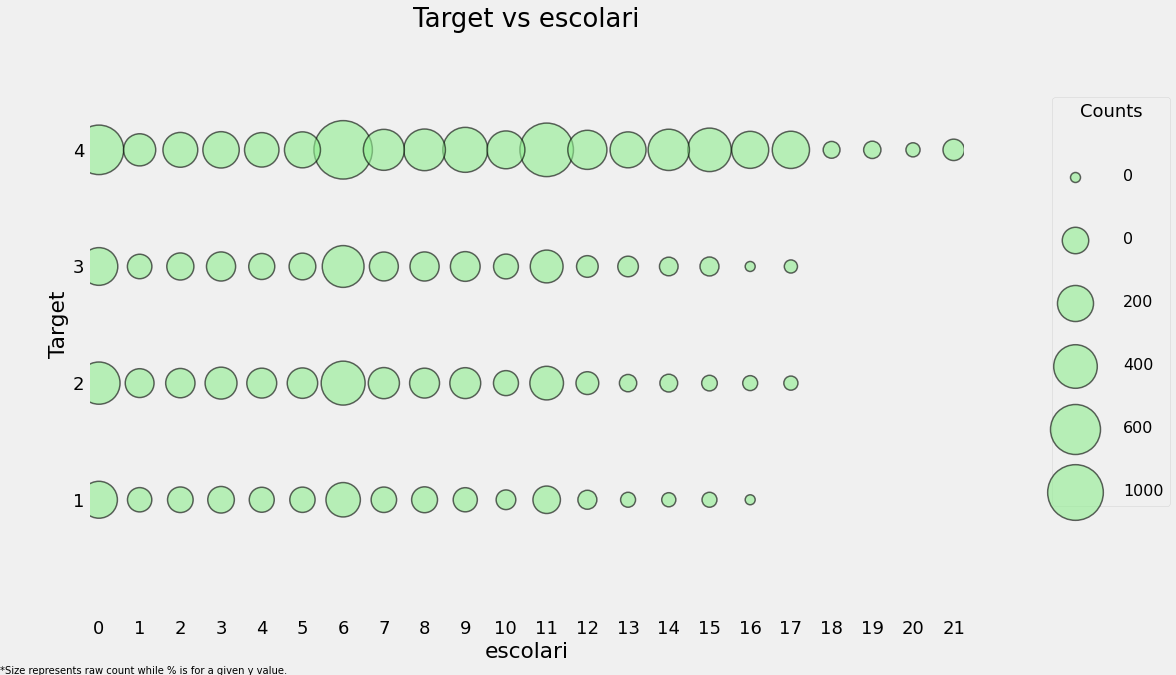

In [29]:
plot_categoricals('escolari', 'Target', data, annotate=False)

각 열의 나머지 결측값은 Imputation 이라고 하는 공정으로 채워집니다. 일반적으로 사용되는 귀책에는 여러 가지 유형이 있으며, 가장 간단하고 효과적인 방법 중 하나는 결측값을 열의 중위수로 채우는 것입니다.

결측값의 마지막 단계로 이러한 값 중 하나가 결측값인 경우에 대한 목표값 분포를 표시할 수 있습니다.

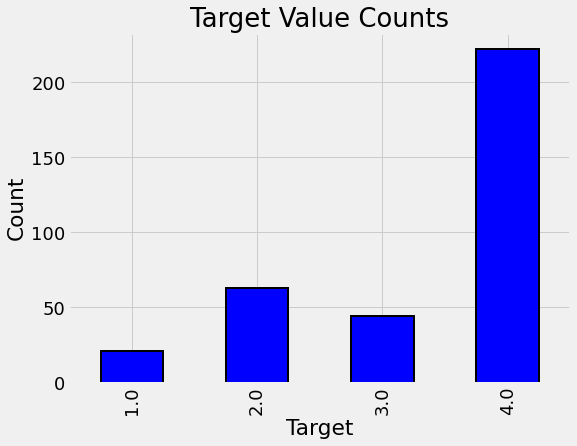

In [30]:
plot_values_counts(data[(data['rez_esc-missing'] == 1)], 'Target')

이 분포는 전체 데이터의 분포와 일치하는 것 같습니다.

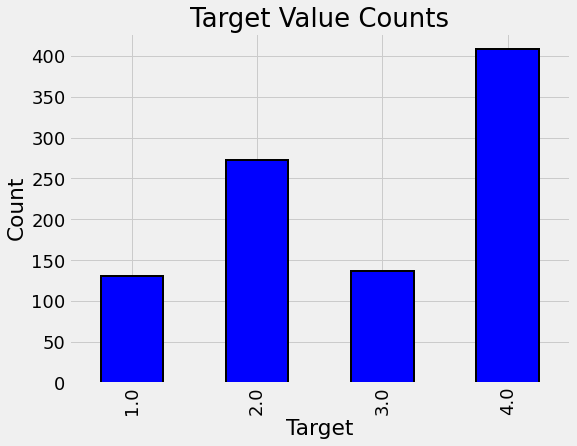

In [31]:
plot_values_counts(data[(data['v2a1-missing'] == 1)], 'Target')

이것은 2: 중간 정도의 빈곤이 더 널리 퍼진다면 더 많은 빈곤의 지표가 될 수 있을 것으로 보입니다.

이것은 중요한 점을 나타냅니다. 때때로 누락된 정보는 주어진 정보만큼 중요합니다.

## Feature Engineering
우리가 할 수 있는 더 많은 탐색적 데이터 분석이 있지만, 먼저 우리는 가계 수준에서 데이터를 통합하는 작업을 해야 합니다. 우리는 이미 각 가정에 대한 정보를 일부 보유하고 있지만, 교육을 위해서는 각 가정에 대해 요약된 모든 정보가 필요할 것입니다. 즉, 주택에 있는 개인을 그룹화(그룹별로)하고 개별 변수의 집계(agg)를 수행하는 것을 의미합니다.

### Column Definitions
때때로 데이터 과학에서는 데이터를 더럽게 파거나 시간이 많이 걸리는 지루한 작업을 해야 합니다. 이것은 분석의 일부입니다. 우리는 데이터 설명을 사용하여 개별 수준과 가구 수준에 있는 열을 정의해야 합니다. 데이터 설명에서 변수 자체를 살펴보는 것 외에 가계 수준에서 변수를 식별하는 다른 방법은 없습니다.

일부 변수를 다른 방식으로 처리해야 하므로 다른 변수를 정의하겠습니다. 각 수준에서 변수를 정의했으면 필요에 따라 변수를 집계하기 시작할 수 있습니다.

프로세스는 다음과 같습니다.

1. 변수를 가정과 개인 수준으로 나눕니다.
2. 개인 수준 데이터에 적합한 집계를 찾습니다.
    + 순서형 변수는 통계 집계를 사용할 수 있습니다.
    + 불린 변수도 집계할 수 있지만 통계량은 더 적습니다.
3. 개별 집계를 가계 수준 데이터에 결합합니다.

#### Define Variable Categories
변수에는 몇 가지 범주가 있습니다.

1. 개별 변수: 이는 가구가 아니라 각 개인의 특성입니다.
    - Boolean: 예 또는 아니오(0 또는 1)
    - Ordered Discrete: 순서가 있는 정수입니다.
2. 가계 변수.
    - Boolean: 예, 아니오
    - Ordered Discrete: 순서가 있는 정수입니다.
    - Continuous numeric
3. 변수 제곱: 데이터의 제곱 변수에서 파생됩니다.
4. ID 변수: 데이터를 식별하며 피처로 사용해서는 안 됩니다.

아래에서는 각 범주의 변수를 수동으로 정의합니다. 이것은 조금 지루하지만 또한 필요합니다.

In [32]:
id_ = ['Id', 'idhogar', 'Target']

In [33]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [34]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [35]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

모든 변수를 다뤘고 반복하지 않았는지 확인해 보겠습니다.

In [38]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter

print('There are no repeats:', np.all(np.array(list(Counter(x).values())) == 1))
print('We covered every variable: ', len(x) == data.shape[1])

There are no repeats: True
We covered every variable:  True


### Squared Variables
첫째, 가장 쉬운 단계: 모든 제곱 변수를 제거합니다. 선형 모형에서 비선형 관계를 학습하는 데 도움이 될 수 있기 때문에 변수가 피처 엔지니어링의 일부로 제곱되거나 변환되는 경우가 있습니다. 그러나 보다 복잡한 모델을 사용하기 때문에 이러한 제곱 형상은 중복됩니다. 그것들은 제곱이 아닌 버전과 높은 상관 관계를 가지고 있기 때문에, 관련 없는 정보를 추가하고 훈련 속도를 늦춤으로써 우리의 모델을 실제로 해칠 수 있습니다.

예를 들어, SQBage 대 age를 살펴보겠습니다.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Squared Age versus Age')

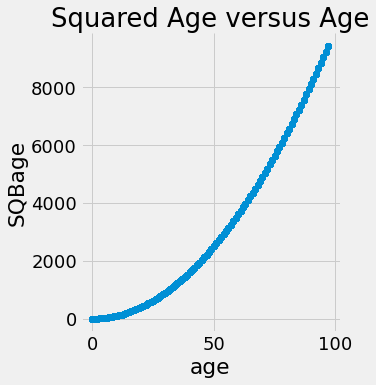

In [39]:
sns.lmplot('age', 'SQBage', data=data, fit_reg = False)
plt.title('Squared Age versus Age')

둘의 상관관계가 매우 높기 때문에 둘다 사용할 필요가 없습니다.

In [40]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)

### Id Variables
이는 매우 간단합니다. 식별을 위해 필요하기 때문에 데이터에 있는 그대로 유지됩니다.

### Household Level Variables
먼저 가장으로 부분집합을 하고 가구 수준 변수로 해보겠습니다.

In [41]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool+ hh_cont + hh_ordered]
heads.shape

(10307, 99)

대부분의 가구 수준 변수의 경우, 이를 그대로 유지할 수 있습니다. 각 가구를 예측하기 위해 이러한 변수를 특징으로 사용합니다. 그러나 일부 중복 변수를 제거하고 기존 데이터에서 파생된 기능을 추가할 수도 있습니다.

### Redundant Household Variables
모든 가계 변수 간의 상관 관계를 살펴보겠습니다. 상관 관계가 너무 높은 경우 상관 관계가 높은 변수 쌍 중 하나를 제거할 수 있습니다.

다음 코드는 0.95 이상의 절대 크기 상관 관계를 가진 변수를 식별합니다.

In [43]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

각 상관 변수 쌍 중 하나를 보여 줍니다. 다른 쌍을 찾기 위해 corr_matrix를 부분 집합으로 만들 수 있습니다.

In [44]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


<AxesSubplot:>

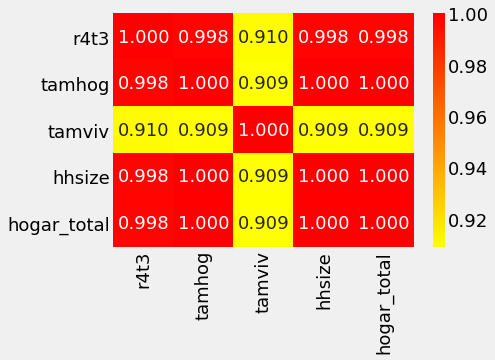

In [45]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs()>0.9, corr_matrix['tamhog'].abs()>0.9],
           annot=True, cmap=plt.cm.autumn_r, fmt='.3f')

집의 크기와 관련된 몇 가지 변수가 있습니다.

- r4t3, 가구원 총계입니다.
- tamhog, 집의 크기입니다.
- tamviv, 집에 사는 사람의 수입니다.
- hhsize, 가정사이즈입니다.
- hogar_total, 가구 내 총 개인 수입니다.
이러한 변수는 모두 서로 높은 상관 관계를 갖습니다. 사실, hhsize는 tamhog 및 hogar_total과 완벽한 상관 관계를 가지고 있습니다. 정보가 중복되므로 이 두 변수를 제거하겠습니다. 또한 r4t3는 h사이즈와 거의 완벽한 상관관계를 가지고 있기 때문에 제거할 수 있습니다.

tamviv는 가정에 살고 있지 않은 가족이 있을 수 있기 때문에 반드시 h사이즈와 같은 것은 아닙니다. 산점도에서 이 차이를 시각화하겠습니다.

In [46]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'House size vs number of persons living in the household')

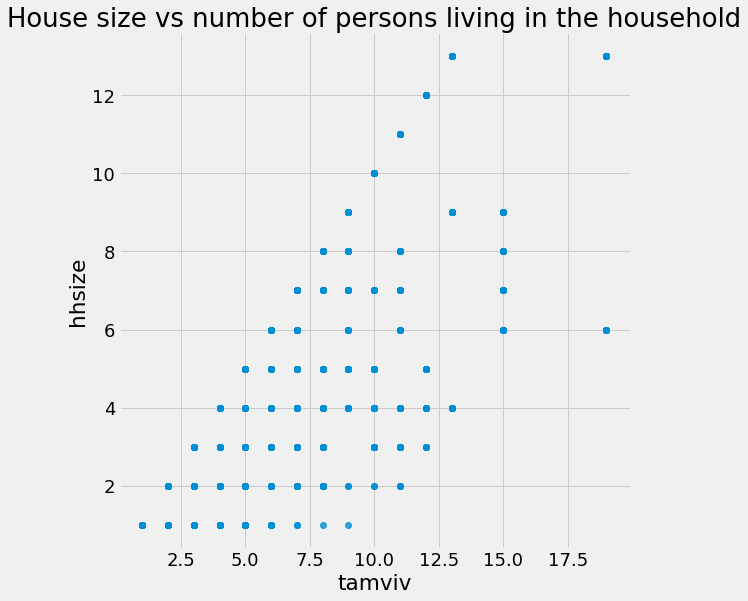

In [47]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size=8)
plt.title('House size vs number of persons living in the household')

많은 사례들을 보면, 가족보다 더 많은 사람들이 살고 있다는 것을 알 수 있습니다. 이는 새로운 피처에 대한 좋은 아이디어를 제공합니다. 이 두 측정치 간의 차이입니다!

이 새로운 피처를 만들어 보겠습니다.

<ipython-input-27-2f73ba78de83>:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy=(row[x]-(1/counts[x].nunique()),


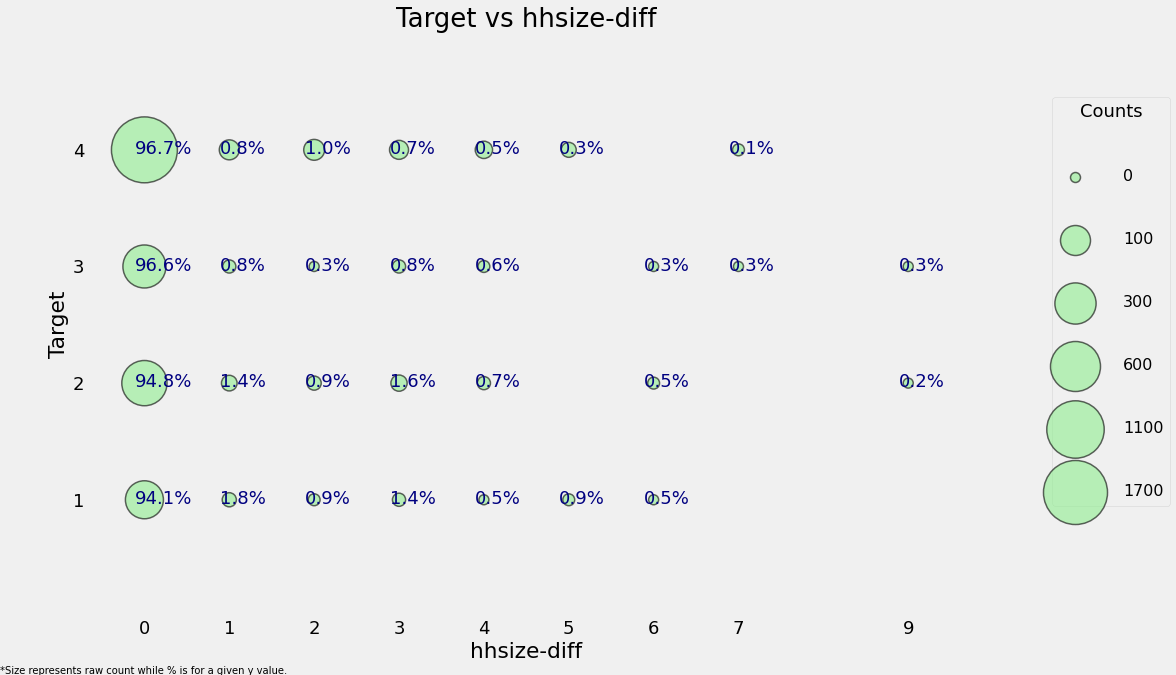

In [48]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

대부분의 가구는 차이가 없지만, 가족구성원보다 그 가구에 사는 사람의 수가 더 많은 경우도 몇 명 있습니다.

다른 중복 변수로 넘어갑시다. 먼저 우리는 coopele을 볼 수 있습니다.

In [49]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9 ]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수들은 가정의 전기가 어디에서 오는지 나타냅니다. 네 가지 옵션이 있는데, 이 두 가지 옵션 중 하나를 가지고 있지 않은 가정은 전기가 없거나(noelec) 개인 공장(planpri)에서 공급받습니다.

### Creating Ordinal Variable
순서형 변수를 만들어 이 네 변수를 하나로 압축해 보겠습니다. 데이터 설명에 따라 직접 매핑하겠습니다.

`
0: No electricity
1: Electricity from cooperative
2: Electricity from CNFL, ICA, ESPH/JASEC
3: Electricity from private plant
`

순서형 변수에는 고유 순서가 있으며, 이를 위해 도메인 지식을 기반으로 자체적인 순서를 선택합니다. 이 새로운 순서 변수를 만든 후, 나머지 네 개는 삭제할 수 있습니다. 여기에는 변수가 없는 가구가 여러 개 있으므로 nan(귀속 시 채워짐)을 사용하고 이 변수에 대한 측정값이 없음을 나타내는 불린 열을 추가할 것입니다.


In [50]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

<ipython-input-27-2f73ba78de83>:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy=(row[x]-(1/counts[x].nunique()),


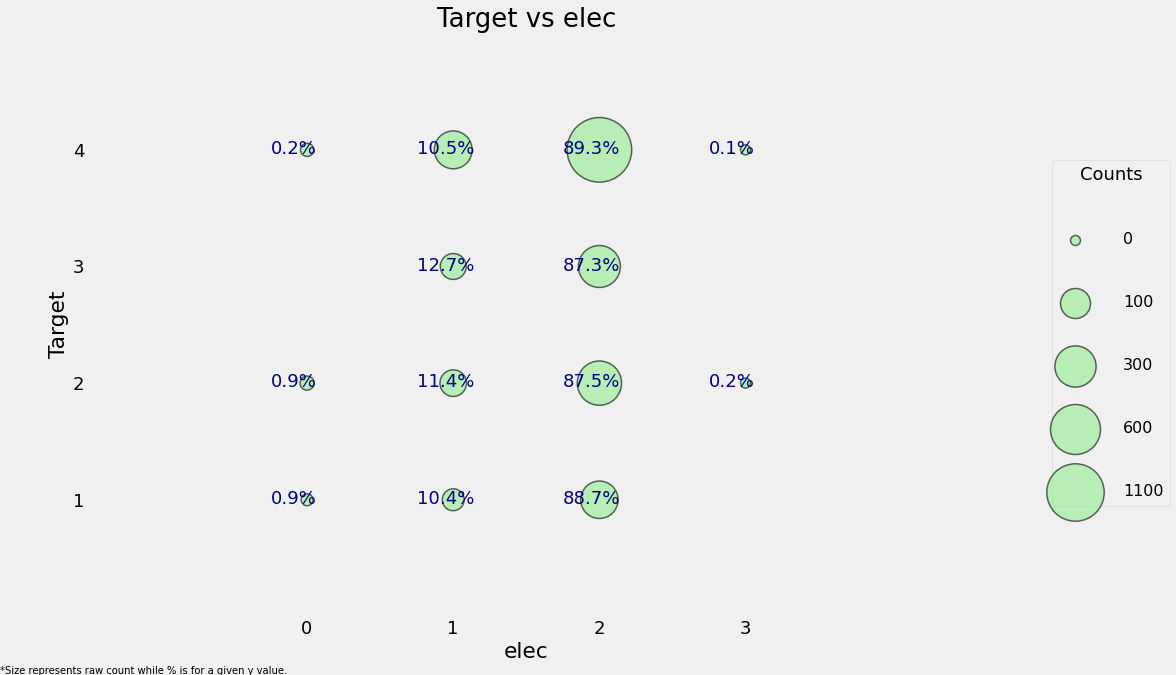

In [54]:
plot_categoricals('elec', 'Target', heads)

타겟값의 모든 값에 대해 가장 일반적인 전기 공급원은 public 리스트 중 하나에서 나온 것임을 알 수 있습니다.

최종 중복 열은 area2입니다. 이것은 그 집이 시골 지역에 있다는 것을 의미하지만, 우리는 그 집이 도시 지역에 있는지 여부를 나타내는 열이 있기 때문에 중복됩니다. 따라서 이 열을 삭제할 수 있습니다.

In [55]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시 지역의 가구(1)가 시골 지역의 가구(0)보다 빈곤 수준이 낮을 가능성이 더 높은 것으로 보입니다.

### Creating Ordinal Variables
집의 벽, 지붕, 바닥에는 각각 세 개의 열이 있습니다. 첫째는 '나쁨', 둘째는 '보통', 셋째는 '좋음'입니다. 우리는 변수를 불린(boolean)으로 둘 수 있지만, 그것들을 순서형 변수로 바꾸는 것이 더 이치에 맞습니다. 왜냐하면 내재된 순서가 있기 때문입니다: 나쁜 > 보통 > 좋음. 이를 위해 np.argmax를 사용하여 각 가정에 대해 0이 아닌 열을 쉽게 찾을 수 있습니다.

순서형 변수를 생성했으면 원래 변수를 삭제할 수 있습니다.

<ipython-input-27-2f73ba78de83>:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(xy=(row[x]-(1/counts[x].nunique()),


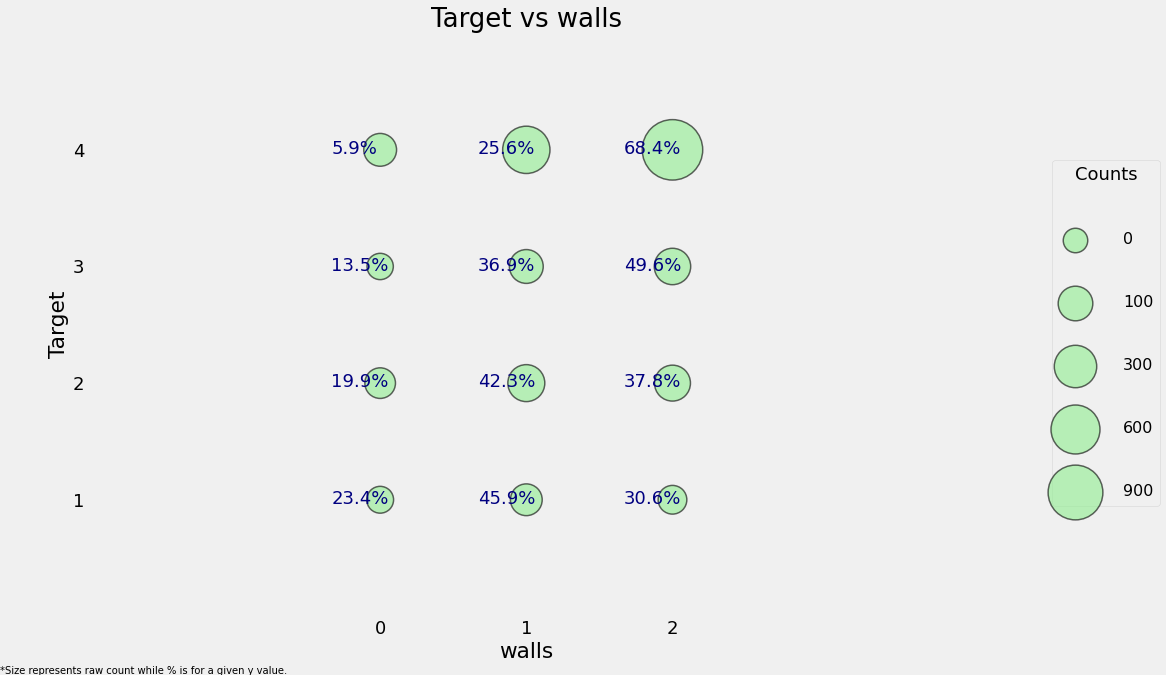

In [56]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                          axis=1)

plot_categoricals('walls', 'Target', heads)

In [57]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                         axis=1)
# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                          axis=1)

## Feature Construction
변수를 순서형 피처에 매핑하는 것 외에도 피처 구성이라고 하는 기존 데이터에서 완전히 새로운 피처를 만들 수도 있습니다. 예를 들어, 방금 만든 이전의 세 가지 특징을 합산하여 주택 구조의 품질을 전반적으로 측정할 수 있습니다.

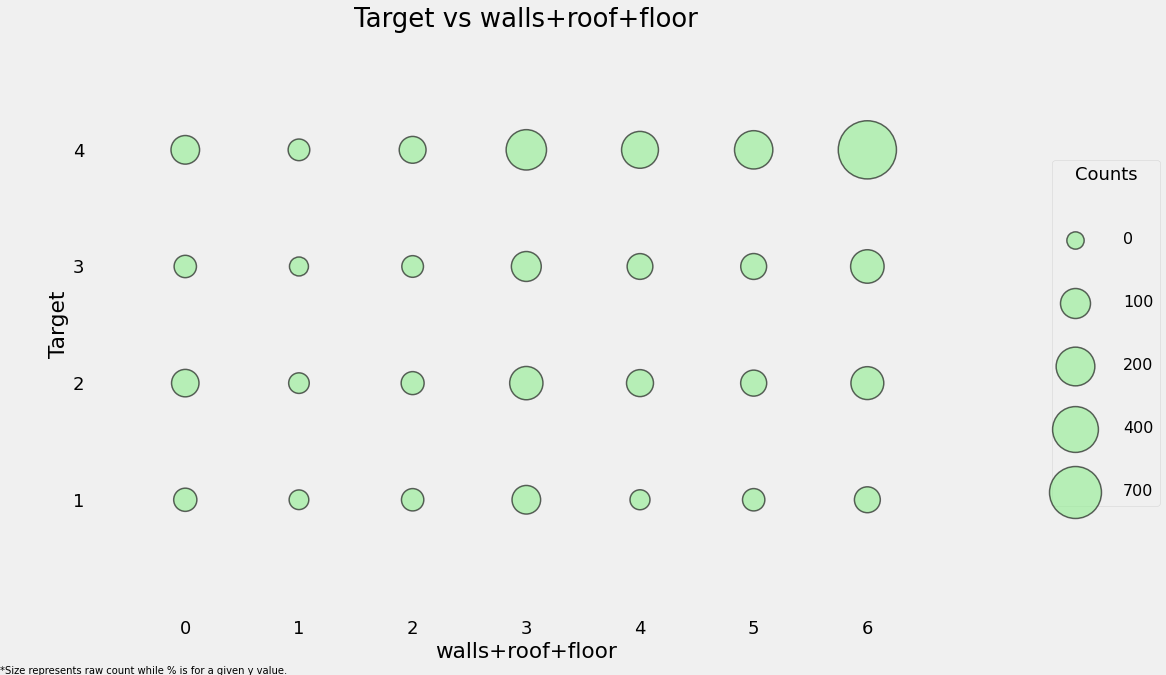

In [58]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

이 새로운 기능은 타겟값 4(최저 빈곤 수준)가 '주택 품질' 변수의 값이 더 높은 경향이 있기 때문에 유용할 수 있습니다.

In [59]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize=True)).rename(columns={'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])
heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])
heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

In [ ]:
m